In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-08-23 04:19:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-08-23 04:19:22 (108 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open('/tmp/sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [7]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs, verbose=1, validation_data=(testing_padded, testing_labels))

Epoch 1/30
625/625 [==============================] - 3s 5ms/step - loss: 0.6499 - accuracy: 0.6100 - val_loss: 0.5334 - val_accuracy: 0.7560
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 0.4021 - accuracy: 0.8427 - val_loss: 0.3744 - val_accuracy: 0.8435
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2989 - accuracy: 0.8812 - val_loss: 0.3474 - val_accuracy: 0.8554
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2479 - accuracy: 0.9018 - val_loss: 0.3422 - val_accuracy: 0.8583
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2120 - accuracy: 0.9179 - val_loss: 0.3482 - val_accuracy: 0.8553
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1843 - accuracy: 0.9312 - val_loss: 0.3562 - val_accuracy: 0.8545
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1622 - accuracy: 0.9402 - val_loss: 0.3779 - val_accuracy: 0.8512
Epoch 

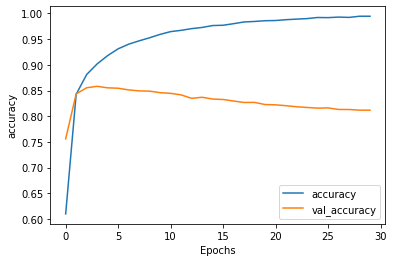

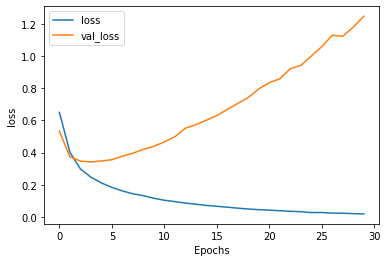

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()


plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]

weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [15]:
import io

out_v = io.open('sarcastic_sentiment_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('sarcastic_sentiment_meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]

  out_m.write(word + "\n")
  out_v.write("\t".join([str(x) for x in embeddings]) +  "\n")

out_v.close()
out_m.close()

In [16]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('sarcastic_sentiment_vecs.tsv')
  files.download('sarcastic_sentiment_meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
sentence = ["granny starting to fear spides in the garden might be real", "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[6.1882764e-01]
 [8.0744343e-08]]


In [22]:
float(model.predict(padded)[0])

0.6188276410102844